In [46]:
import model
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os

In [47]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
network = model.get_network(model.Network.GROUP_NORM).to(device)
summary(network, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
         GroupNorm-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
        GroupNorm-12            [-1, 8, 14, 14]              16
    

/content/model.py:114: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [48]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [49]:
from tqdm import tqdm

train_losses = []
train_acc = []
test_losses = []
test_acc = []
missclassified = []
missclassified_value = []
expected_label = []
gn_train_losses, gn_train_acc, gn_test_losses, gn_test_acc = [], [], [], []
ln_train_losses, ln_train_acc, ln_test_losses, ln_test_acc = [], [], [], []
bn_train_losses, bn_train_acc, bn_test_losses, bn_test_acc = [], [], [], []


def train(model, device, train_loader, optimizer, epoch, use_lambda = False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    lambda_l1 = 0.0004

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        y_pred = model(data)

        loss = F.nll_loss(y_pred, target)

        if use_lambda :
          l1 = 0
          for params in model.parameters():
            l1 = l1 + params.abs().sum()
          '''  
          #lambda_l1 = 0.0004
          if lambda_l1 == 0: #First epoch lambda calculation
            lambda_l1 = loss/(l1*10)
            print('loss: ', loss)
            print('l1: ', l1)
            print('lambda_l1: ', lambda_l1)
          '''
          loss = loss + lambda_l1*l1

        train_losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
        train_acc.append(100*correct/processed)

    return train_losses, train_acc

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-
            results = pred.eq(target.view_as(pred))
            correct += results.sum().item()
            #Collecting missclassified images
            for i in range(0,len(target)):
              if len(missclassified) < 10 and not results[i]:
                missclassified.append(data[i])
                expected_label.append(target[i])
                missclassified_value.append(pred[i])
                  

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_acc

In [50]:
import matplotlib.pyplot as plt

network = model.get_network(model.Network.GROUP_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
train_acc = []
test_losses = []
test_acc = []

for epoch in range(1, 16):
    gn_train_losses, gn_train_acc = train(network, device, train_loader, optimizer, epoch)
    gn_test_losses, gn_test_acc = test(network, device, test_loader)


Epoch=1 Loss=0.14965088665485382 batch_id=937 Accuracy=87.32%: 100%|██████████| 938/938 [00:32<00:00, 28.55it/s]



Test set: Average loss: 0.0740, Accuracy: 9804/10000 (98.04%)



Epoch=2 Loss=0.04764918237924576 batch_id=937 Accuracy=96.83%: 100%|██████████| 938/938 [00:25<00:00, 37.42it/s]



Test set: Average loss: 0.0522, Accuracy: 9844/10000 (98.44%)



Epoch=3 Loss=0.08550190925598145 batch_id=937 Accuracy=97.55%: 100%|██████████| 938/938 [00:24<00:00, 37.76it/s]



Test set: Average loss: 0.0472, Accuracy: 9870/10000 (98.70%)



Epoch=4 Loss=0.02727905474603176 batch_id=937 Accuracy=97.92%: 100%|██████████| 938/938 [00:25<00:00, 36.11it/s]



Test set: Average loss: 0.0339, Accuracy: 9901/10000 (99.01%)



Epoch=5 Loss=0.06263162195682526 batch_id=937 Accuracy=98.20%: 100%|██████████| 938/938 [00:24<00:00, 38.55it/s]



Test set: Average loss: 0.0357, Accuracy: 9900/10000 (99.00%)



Epoch=6 Loss=0.13830704987049103 batch_id=937 Accuracy=98.29%: 100%|██████████| 938/938 [00:24<00:00, 38.58it/s]



Test set: Average loss: 0.0365, Accuracy: 9892/10000 (98.92%)



Epoch=7 Loss=0.08553171902894974 batch_id=937 Accuracy=98.49%: 100%|██████████| 938/938 [00:24<00:00, 38.71it/s]



Test set: Average loss: 0.0304, Accuracy: 9913/10000 (99.13%)



Epoch=8 Loss=0.03671471029520035 batch_id=937 Accuracy=98.50%: 100%|██████████| 938/938 [00:24<00:00, 38.35it/s]



Test set: Average loss: 0.0296, Accuracy: 9914/10000 (99.14%)



Epoch=9 Loss=0.1879219263792038 batch_id=937 Accuracy=98.59%: 100%|██████████| 938/938 [00:25<00:00, 37.34it/s]



Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)



Epoch=10 Loss=0.18057924509048462 batch_id=937 Accuracy=98.64%: 100%|██████████| 938/938 [00:24<00:00, 38.35it/s]



Test set: Average loss: 0.0262, Accuracy: 9922/10000 (99.22%)



Epoch=11 Loss=0.05710477754473686 batch_id=937 Accuracy=98.72%: 100%|██████████| 938/938 [00:24<00:00, 38.34it/s]



Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)



Epoch=12 Loss=0.011738564819097519 batch_id=937 Accuracy=98.71%: 100%|██████████| 938/938 [00:24<00:00, 38.19it/s]



Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)



Epoch=13 Loss=0.01851530186831951 batch_id=937 Accuracy=98.83%: 100%|██████████| 938/938 [00:25<00:00, 37.35it/s]



Test set: Average loss: 0.0293, Accuracy: 9919/10000 (99.19%)



Epoch=14 Loss=0.08591222018003464 batch_id=937 Accuracy=98.88%: 100%|██████████| 938/938 [00:24<00:00, 37.60it/s]



Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)



Epoch=15 Loss=0.026583293452858925 batch_id=937 Accuracy=98.92%: 100%|██████████| 938/938 [00:24<00:00, 38.05it/s]



Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)



Missclassification 

Correct Labels: 
6 6 9 8 1 

9 6 5 8 8 

Prediction : 
0 0 1 9 3 

7 5 3 0 7 

Images


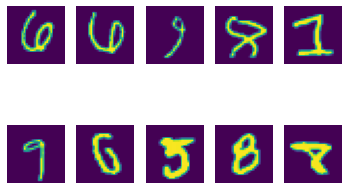

In [51]:
print('Missclassification \n')
for i in range(0, 10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(torch.stack(missclassified).cpu().detach().numpy()[i].squeeze())

print('Correct Labels: ')
for i in range(0, len(missclassified)):
  output_line += str(expected_label[i].item()) + ' '
  if i ==int((len(missclassified)-1)/2) or i==len(missclassified)-1:
    print(output_line + '\n')
    output_line = ''

print('Prediction : ')
for i in range(0, len(missclassified)):
  output_line += str(missclassified_value[i].item()) + ' '
  if i ==int((len(missclassified)-1)/2) or i==len(missclassified)-1:
    print(output_line + '\n')
    output_line = ''

#cleanup lists
missclassified = []
expected_label = []
missclassified_value = []

print('Images')

In [52]:
network = model.get_network(model.Network.LAYER_NORM).to(device)
summary(network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
         LayerNorm-3           [-1, 10, 28, 28]          15,680
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
         LayerNorm-7           [-1, 16, 28, 28]          25,088
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
        LayerNorm-12            [-1, 8, 14, 14]           3,136
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/content/model.py:211: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [53]:
#network = model.get_network(model.Network.LAYER_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
train_acc = []
test_losses = []
test_acc = []

for epoch in range(1, 16):
    ln_train_losses, ln_train_acc = train(network, device, train_loader, optimizer, epoch)
    ln_test_losses, ln_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.2999889552593231 batch_id=937 Accuracy=88.86%: 100%|██████████| 938/938 [00:33<00:00, 28.06it/s]



Test set: Average loss: 0.0758, Accuracy: 9791/10000 (97.91%)



Epoch=2 Loss=0.09282763302326202 batch_id=937 Accuracy=96.92%: 100%|██████████| 938/938 [00:23<00:00, 39.17it/s]



Test set: Average loss: 0.0436, Accuracy: 9881/10000 (98.81%)



Epoch=3 Loss=0.28662505745887756 batch_id=937 Accuracy=97.75%: 100%|██████████| 938/938 [00:23<00:00, 39.36it/s]



Test set: Average loss: 0.0386, Accuracy: 9884/10000 (98.84%)



Epoch=4 Loss=0.10336264222860336 batch_id=937 Accuracy=98.07%: 100%|██████████| 938/938 [00:24<00:00, 38.91it/s]



Test set: Average loss: 0.0365, Accuracy: 9887/10000 (98.87%)



Epoch=5 Loss=0.0663108229637146 batch_id=937 Accuracy=98.29%: 100%|██████████| 938/938 [00:24<00:00, 37.58it/s]



Test set: Average loss: 0.0307, Accuracy: 9905/10000 (99.05%)



Epoch=6 Loss=0.17832228541374207 batch_id=937 Accuracy=98.45%: 100%|██████████| 938/938 [00:23<00:00, 40.10it/s]



Test set: Average loss: 0.0275, Accuracy: 9912/10000 (99.12%)



Epoch=7 Loss=0.12443371117115021 batch_id=937 Accuracy=98.42%: 100%|██████████| 938/938 [00:23<00:00, 39.33it/s]



Test set: Average loss: 0.0290, Accuracy: 9914/10000 (99.14%)



Epoch=8 Loss=0.00875511858612299 batch_id=937 Accuracy=98.65%: 100%|██████████| 938/938 [00:24<00:00, 38.10it/s]



Test set: Average loss: 0.0271, Accuracy: 9918/10000 (99.18%)



Epoch=9 Loss=0.07980145514011383 batch_id=937 Accuracy=98.69%: 100%|██████████| 938/938 [00:23<00:00, 39.18it/s]



Test set: Average loss: 0.0253, Accuracy: 9915/10000 (99.15%)



Epoch=10 Loss=0.013098673895001411 batch_id=937 Accuracy=98.70%: 100%|██████████| 938/938 [00:23<00:00, 39.49it/s]



Test set: Average loss: 0.0230, Accuracy: 9925/10000 (99.25%)



Epoch=11 Loss=0.12468984723091125 batch_id=937 Accuracy=98.82%: 100%|██████████| 938/938 [00:23<00:00, 39.94it/s]



Test set: Average loss: 0.0236, Accuracy: 9922/10000 (99.22%)



Epoch=12 Loss=0.030203131958842278 batch_id=937 Accuracy=98.86%: 100%|██████████| 938/938 [00:23<00:00, 39.11it/s]



Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)



Epoch=13 Loss=0.0025571819860488176 batch_id=937 Accuracy=98.88%: 100%|██████████| 938/938 [00:24<00:00, 38.76it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)



Epoch=14 Loss=0.007738321553915739 batch_id=937 Accuracy=98.90%: 100%|██████████| 938/938 [00:24<00:00, 38.90it/s]



Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)



Epoch=15 Loss=0.015638766810297966 batch_id=937 Accuracy=98.98%: 100%|██████████| 938/938 [00:25<00:00, 37.48it/s]



Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)



Missclassification 

Correct Labels: 
3 4 9 4 8 

3 8 6 5 3 

Prediction : 
5 9 4 9 6 

2 3 1 0 2 

Images


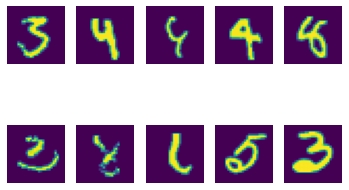

In [54]:
print('Missclassification \n')
for i in range(0, 10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(torch.stack(missclassified).cpu().detach().numpy()[i].squeeze())

print('Correct Labels: ')
for i in range(0, len(missclassified)):
  output_line += str(expected_label[i].item()) + ' '
  if i ==int((len(missclassified)-1)/2) or i==len(missclassified)-1:
    print(output_line + '\n')
    output_line = ''

print('Prediction : ')
for i in range(0, len(missclassified)):
  output_line += str(missclassified_value[i].item()) + ' '
  if i ==int((len(missclassified)-1)/2) or i==len(missclassified)-1:
    print(output_line + '\n')
    output_line = ''

#cleanup lists
missclassified = []
expected_label = []
missclassified_value = []

print('Images')

In [55]:
network = model.get_network(model.Network.BATCH_NORM).to(device)
summary(network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/content/model.py:308: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [56]:
network = model.get_network(model.Network.BATCH_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
train_acc = []
test_losses = []
test_acc = []

for epoch in range(1, 16):
    bn_train_losses, bn_train_acc = train(network, device, train_loader, optimizer, epoch, use_lambda = True)
    bn_test_losses, bn_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.36217600107192993 batch_id=937 Accuracy=90.41%: 100%|██████████| 938/938 [00:26<00:00, 36.00it/s]



Test set: Average loss: 0.0643, Accuracy: 9793/10000 (97.93%)



Epoch=2 Loss=0.3840905427932739 batch_id=937 Accuracy=96.59%: 100%|██████████| 938/938 [00:25<00:00, 36.33it/s]



Test set: Average loss: 0.0604, Accuracy: 9814/10000 (98.14%)



Epoch=3 Loss=0.2833991050720215 batch_id=937 Accuracy=97.06%: 100%|██████████| 938/938 [00:25<00:00, 36.15it/s]



Test set: Average loss: 0.0503, Accuracy: 9849/10000 (98.49%)



Epoch=4 Loss=0.6140828132629395 batch_id=937 Accuracy=97.22%: 100%|██████████| 938/938 [00:25<00:00, 36.09it/s]



Test set: Average loss: 0.0439, Accuracy: 9867/10000 (98.67%)



Epoch=5 Loss=0.24126075208187103 batch_id=937 Accuracy=97.32%: 100%|██████████| 938/938 [00:25<00:00, 36.27it/s]



Test set: Average loss: 0.0435, Accuracy: 9867/10000 (98.67%)



Epoch=6 Loss=0.3590990900993347 batch_id=937 Accuracy=97.42%: 100%|██████████| 938/938 [00:26<00:00, 35.74it/s]



Test set: Average loss: 0.0452, Accuracy: 9873/10000 (98.73%)



Epoch=7 Loss=0.2772316634654999 batch_id=937 Accuracy=97.39%: 100%|██████████| 938/938 [00:26<00:00, 35.05it/s]



Test set: Average loss: 0.0421, Accuracy: 9863/10000 (98.63%)



Epoch=8 Loss=0.3154352605342865 batch_id=937 Accuracy=97.45%: 100%|██████████| 938/938 [00:25<00:00, 36.29it/s]



Test set: Average loss: 0.0386, Accuracy: 9889/10000 (98.89%)



Epoch=9 Loss=0.2768058180809021 batch_id=937 Accuracy=97.54%: 100%|██████████| 938/938 [00:25<00:00, 36.36it/s]



Test set: Average loss: 0.0378, Accuracy: 9885/10000 (98.85%)



Epoch=10 Loss=0.2064865678548813 batch_id=937 Accuracy=97.58%: 100%|██████████| 938/938 [00:25<00:00, 36.30it/s]



Test set: Average loss: 0.0371, Accuracy: 9898/10000 (98.98%)



Epoch=11 Loss=0.335493803024292 batch_id=937 Accuracy=97.61%: 100%|██████████| 938/938 [00:25<00:00, 36.62it/s]



Test set: Average loss: 0.0488, Accuracy: 9830/10000 (98.30%)



Epoch=12 Loss=0.19641457498073578 batch_id=937 Accuracy=97.50%: 100%|██████████| 938/938 [00:25<00:00, 36.94it/s]



Test set: Average loss: 0.0369, Accuracy: 9884/10000 (98.84%)



Epoch=13 Loss=0.20581068098545074 batch_id=937 Accuracy=97.62%: 100%|██████████| 938/938 [00:25<00:00, 36.45it/s]



Test set: Average loss: 0.0468, Accuracy: 9845/10000 (98.45%)



Epoch=14 Loss=0.22532521188259125 batch_id=937 Accuracy=97.59%: 100%|██████████| 938/938 [00:26<00:00, 36.03it/s]



Test set: Average loss: 0.0337, Accuracy: 9892/10000 (98.92%)



Epoch=15 Loss=0.2543012201786041 batch_id=937 Accuracy=97.74%: 100%|██████████| 938/938 [00:25<00:00, 36.43it/s]



Test set: Average loss: 0.0390, Accuracy: 9873/10000 (98.73%)



Missclassification 

Correct Labels: 
4 4 7 9 9 

7 9 3 3 1 

Prediction : 
9 7 2 7 4 

2 7 5 7 7 

Images


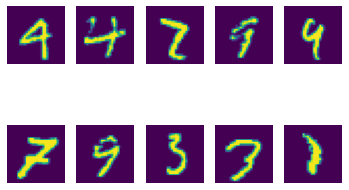

In [57]:
print('Missclassification \n')
for i in range(0, 10):
  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.imshow(torch.stack(missclassified).cpu().detach().numpy()[i].squeeze())

print('Correct Labels: ')
for i in range(0, len(missclassified)):
  output_line += str(expected_label[i].item()) + ' '
  if i ==int((len(missclassified)-1)/2) or i==len(missclassified)-1:
    print(output_line + '\n')
    output_line = ''

print('Prediction : ')
for i in range(0, len(missclassified)):
  output_line += str(missclassified_value[i].item()) + ' '
  if i ==int((len(missclassified)-1)/2) or i==len(missclassified)-1:
    print(output_line + '\n')
    output_line = ''

#cleanup lists
missclassified = []
expected_label = []
missclassified_value = []

print('Images')

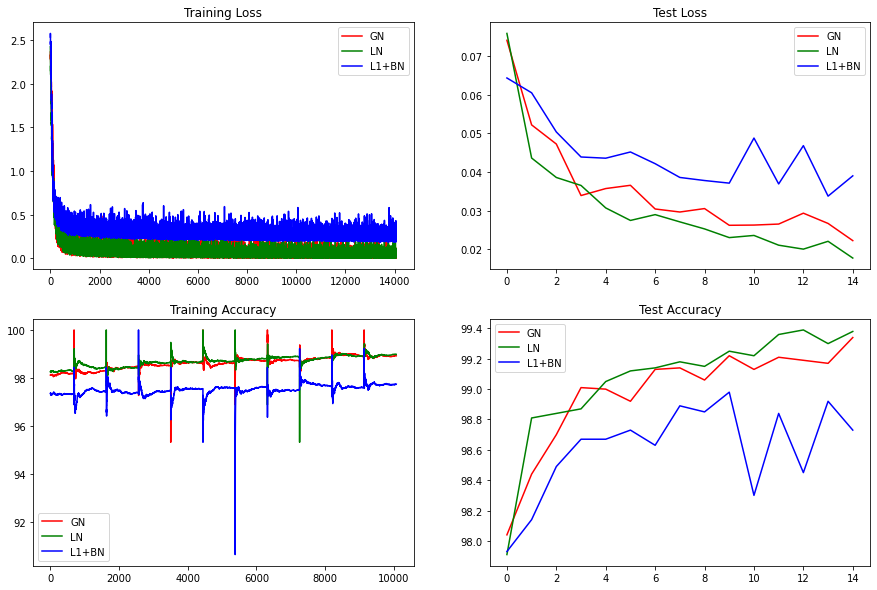

In [58]:
from torch.functional import Tensor
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.stack(gn_train_losses).cpu().detach().numpy(), color='r', label='GN')
axs[0, 0].plot(torch.stack(ln_train_losses).cpu().detach().numpy(), color='g', label='LN')
axs[0, 0].plot(torch.stack(bn_train_losses).cpu().detach().numpy(), color='b', label='L1+BN')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(gn_train_acc[4000:], color='r', label='GN')
axs[1, 0].plot(ln_train_acc[4000:], color='g', label='LN')
axs[1, 0].plot(bn_train_acc[4000:], color='b', label='L1+BN')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(gn_test_losses, color='r', label='GN')
axs[0, 1].plot(ln_test_losses, color='g', label='LN')
axs[0, 1].plot(bn_test_losses, color='b', label='L1+BN')
axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
axs[1, 1].plot(gn_test_acc, color='r', label='GN')
axs[1, 1].plot(ln_test_acc, color='g', label='LN')
axs[1, 1].plot(bn_test_acc, color='b', label='L1+BN')
axs[1, 1].set_title("Test Accuracy")
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
